# **Part Three of the Course Project**
In this project, you will build a graph of sentences from a U.S. President's inaugural speech and apply the [PageRank](https://networkx.org/documentation/networkx-1.7/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html) algorithm to rank the sentences by their importance score, referred to as 'Rank' herein. You will compute correlation using the Gramian matrix built from TF-IDF document term matrix (DTM). The more a given sentance is "correlated" with other sentences, the greater its importance.
<hr style="border-top: 2px solid #606366; background: transparent;">


# **Setup**
Reset the Python environment to clear it of any previously loaded variables, functions, or libraries. Then, in the following code cell, load the necessary packages and download the inaugural corpus of presidential speeches.

In [2]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell
import nltk, re, seaborn as sns, matplotlib.pyplot as plt, pandas as pd, numpy as np, networkx as nx, unittest
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.testing import assert_equal as eq, assert_almost_equal as aeq
import unittest
from colorunittest import run_unittest

_ = nltk.download(['punkt', 'inaugural'], quiet=True)  # load punctuation set and Gutenberg corporus

# Tasks

## Task 1. Retrieve a list of sentences for the file ID

You will complete the `GetSpeech()` function, which retrieves a list of sentences for the given file ID.

In [3]:
FIDs = nltk.corpus.inaugural.fileids()[:59]  # load file IDs (incl. 2021-Biden). This list grows over years
print(FIDs[-5:]) 

['2005-Bush.txt', '2009-Obama.txt', '2013-Obama.txt', '2017-Trump.txt', '2021-Biden.txt']


In [4]:
LsDocs = [nltk.corpus.inaugural.raw(fid) for fid in FIDs]
[s[:100]+'...' for s in LsDocs[-5:]]

['Vice President Cheney, Mr. Chief Justice, President Carter, President Bush, President Clinton, membe...',
 'My fellow citizens:\n\nI stand here today humbled by the task before us, grateful for the trust you ha...',
 'Thank you. Thank you so much.\n\nVice President Biden, Mr. Chief Justice, Members of the United States...',
 'Chief Justice Roberts, President Carter, President Clinton, President Bush, President Obama, fellow ...',
 'Chief Justice Roberts, Vice President Harris, Speaker Pelosi, Leader Schumer, Leader McConnell, Vice...']

In [19]:
def GetSpeech(fid:'nltk file id'='2017-Trump.txt') -> [str]:
    '''Takes fid for an inaugural speech and retrieves the speech as string using raw() method.
        Use nltk's sent_tokenize() to parse the string into sentences. 
        Leave other arguments of NLTK functions with their default values.
    Input: NLTK's file id for inaugural speeches
    Returns: list of string sentences from the presidential speech
    '''
    speech_raw = nltk.corpus.inaugural.raw(fid)
    LsSents = nltk.sent_tokenize(speech_raw)
    return LsSents

LsSents = GetSpeech()
LsSents[:2]

['Chief Justice Roberts, President Carter, President Clinton, President Bush, President Obama, fellow Americans, and people of the world: Thank you.',
 'We, the citizens of America, are now joined in a great national effort to rebuild our country and restore its promise for all of our people.']

The following cell validates the output returned by your function. Evaluate the failed tests and correct your function accordingly.

In [20]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_GetSpeech(unittest.TestCase):
    def test_00(self): eq(type(LsSents), list)          # verify type of LsSents
    def test_01(self): eq(type(LsSents[0]), str)        # verify type of first element of LsSents
    def test_02(self): eq(len(LsSents), 90)             # verify count of sentences
    def test_03(self): eq(len(LsSents[0].split()), 20)  # verify count of words in the first sentence
    def test_04(self): eq(LsSents[0][:21], 'Chief Justice Roberts')  # verify count of words in the first sentence


Ran 5 tests in 0.001s

OK
test_00 (__main__.test_GetSpeech) ... ok
test_01 (__main__.test_GetSpeech) ... ok
test_02 (__main__.test_GetSpeech) ... ok
test_03 (__main__.test_GetSpeech) ... ok
test_04 (__main__.test_GetSpeech) ... ok

----------------------------------------------------------------------



## Task 2. Build a TF-IDF DTM

Complete the `GetDTM()` function, which takes a list of sentences and builds a TF-IDF DTM with default parameters.

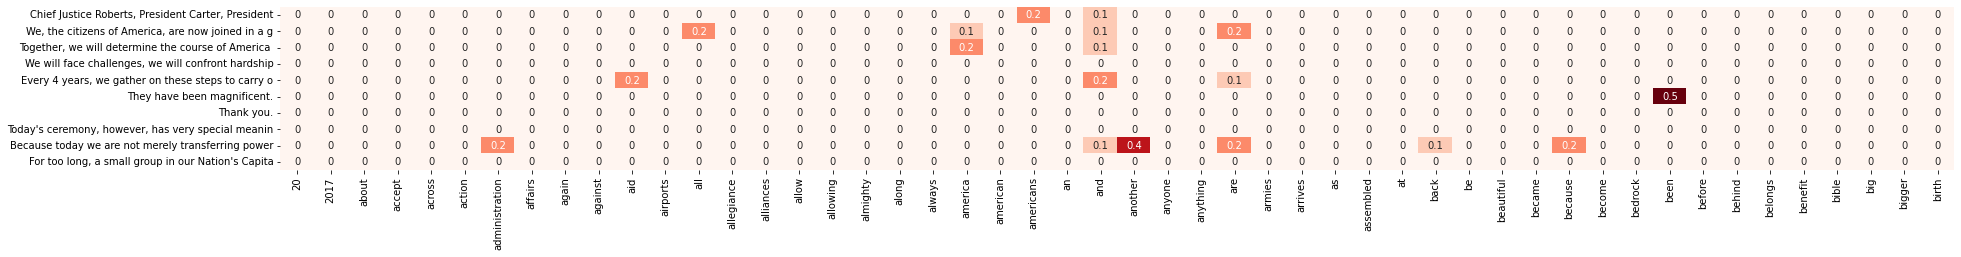

In [21]:
def GetDTM(LsSents=['']) -> pd.DataFrame:
    '''Takes a list of sentence strings and returns a TF-IDF document term matrix (DTM) wrapped in a dataframe.
        
        Complete the following tasks:
        1. Use default parameters of TfidfVectorizer() to create an object. 
        2. Then fit and transform the list of strings.
        3. Finally, convert sparse matrix output to a numpy array and create a dataframe from it, 
           formatting as follows:
            * Set the row index to just the first 50 characters of each sentence.
            * Set the column index to the extracted vocabulary using tv.get_feature_names().   
            
    See TfidfVectorizer documentation or previous exercises on how to extract the vocabulary.
    
    Input: list of sentence strings from a document (such as inaugural speech)
    Returns: DTM dataframe with rows as sentences and columns as vocabulary words.
    '''
    tv = TfidfVectorizer()
    tfidf_matrix = tv.fit_transform(LsSents)
    dense_matrix = tfidf_matrix.toarray()
    vocab = tv.get_feature_names()
    dfDTM = pd.DataFrame(dense_matrix, columns=vocab)
    dfDTM.index = [sentence[:50] for sentence in LsSents]
    return dfDTM
    return dfDTM
    
dfDTM = GetDTM(LsSents)

def PlotDTM(df):
    plt.figure(figsize = (30,3))
    sns.heatmap(df.iloc[:10, :50].round(1), annot=True, cbar=False, cmap='Reds');
PlotDTM(dfDTM)

This cell evaluates the output of your function. Carefully evaluate any failed tests.

In [22]:
# TEST & AUTOGRADE CELL
@run_unittest
class test_GetDTM(unittest.TestCase):
    def test_00(self): eq(type(dfDTM), pd.core.frame.DataFrame)    # verify whether function returns a data frame
    def test_01(self): eq(dfDTM.shape, (90,534))                   # verify DTM dimensions
    def test_02(self): eq('chief' in dfDTM.columns, True)          # verify if vocabulary contains 'chief'
    def test_03(self): eq('infrastructure' in dfDTM.columns, True) # verify if vocabulary contains 'infrastructure'
    def test_04(self): eq('administration' in dfDTM.columns, True) # verify if vocabulary contains 'administration'
    def test_05(self): eq(max(len(s) for s in dfDTM.index), 50)    # verify length of sentence chunks used as indices
    def test_06(self): eq((dfDTM!=0).sum().sum(), 1223)            # verify the count of non-zero weights
    def test_07(self): eq((dfDTM==0).mean().mean(), 0.9745526425301707) # verify sparsity, i.e. fraction of zeros
    def test_08(self): eq(dfDTM.mean().mean(), 0.006177271961164105)  # verify the mean of DTM
    def test_09(self): eq(dfDTM.sum()['chief'], 0.20275874730023774)  # verify sum of weights for 'chief'
    def test_10(self): eq(dfDTM.sum()['great'], 1.4017900224974988)   # verify sum of weights for 'great'
    def test_11(self): eq(dfDTM.sum(axis=1)[0], 3.3081547440454915)   # verify sum of weights for the first sentence  


Ran 12 tests in 0.017s

OK
test_00 (__main__.test_GetDTM) ... ok
test_01 (__main__.test_GetDTM) ... ok
test_02 (__main__.test_GetDTM) ... ok
test_03 (__main__.test_GetDTM) ... ok
test_04 (__main__.test_GetDTM) ... ok
test_05 (__main__.test_GetDTM) ... ok
test_06 (__main__.test_GetDTM) ... ok
test_07 (__main__.test_GetDTM) ... ok
test_08 (__main__.test_GetDTM) ... ok
test_09 (__main__.test_GetDTM) ... ok
test_10 (__main__.test_GetDTM) ... ok
test_11 (__main__.test_GetDTM) ... ok

----------------------------------------------------------------------



## Task 3. Retrieve a Gramian matrix of correlations 

Complete the `GetGramian()` function, which takes a DTM data frame and returns a Gramian matrix of correlations between sentences, then displayed in rows in `dfDTM`.

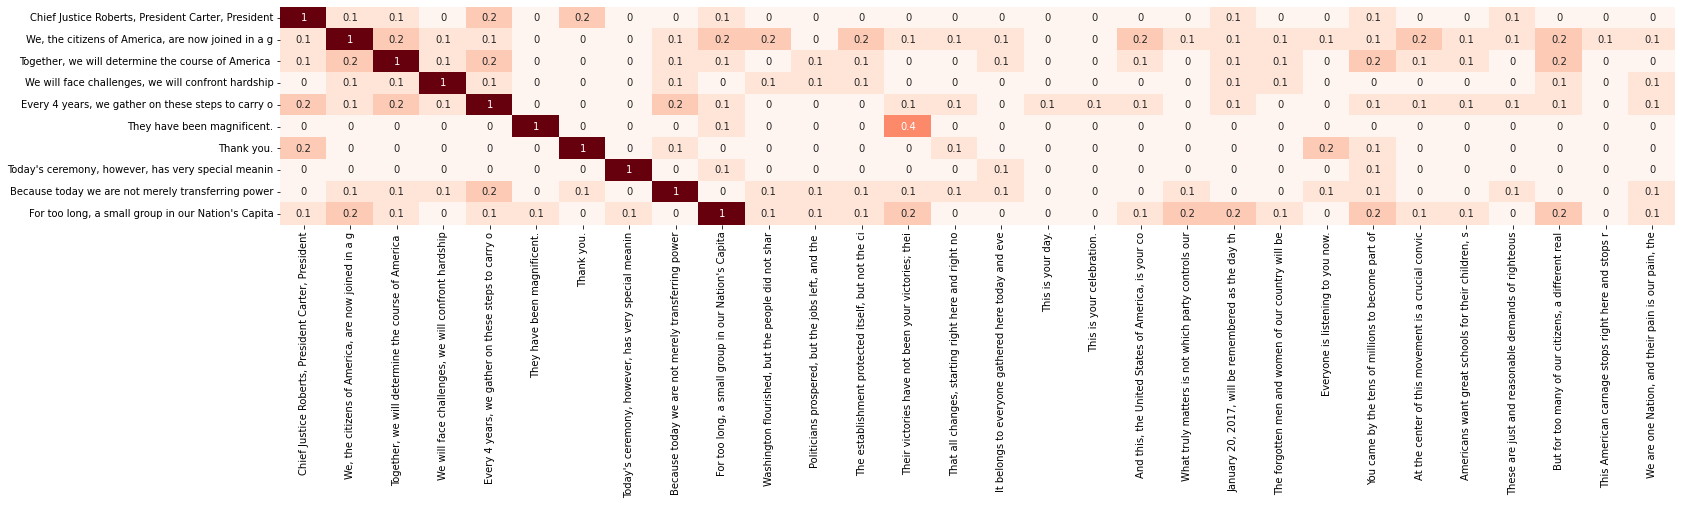

In [23]:
def GetGramian(dfDTM) -> np.array:
    '''Return a symmetric Gramian (or Gram) matrix of correlations between sentences (as DataFrame object).
    Input: DTM dataframe computed in GetDTM()
    Returns: square/symmetric matrix of sentence correlations, which can be computed as a Gram matrix
        wrapped into a DataFrame object
    '''
    sentence_vectors = dfDTM.values
    num_sentences = len(sentence_vectors)
    cosine_sim = np.zeros((num_sentences, num_sentences))


    for i in range(num_sentences):
        for j in range(i, num_sentences):

            dot_product = np.dot(sentence_vectors[i], sentence_vectors[j])
            norm_i = np.linalg.norm(sentence_vectors[i])
            norm_j = np.linalg.norm(sentence_vectors[j])
            cosine_sim[i, j] = cosine_sim[j, i] = dot_product / (norm_i * norm_j)  # Symmetric matrix
    
    dfSim = pd.DataFrame(cosine_sim, index=dfDTM.index, columns=dfDTM.index)
    return dfSim  # a data frame of a correlation matrix of sentence vectors from TF-IDF DTM

dfSim = GetGramian(dfDTM)

def PlotSimMatrix(df:pd.DataFrame) -> None:
    '''Function to plot a heatmap of a correlation submatrix passed as a dataframe'''
    plt.figure(figsize=(25, 4))
    sns.heatmap(pd.DataFrame(df).round(1), annot=True, cbar=False, cmap='Reds');

PlotSimMatrix(dfSim.iloc[:10,:30])  # plot top left submatrix as a heatmap (in color)

The following cell validates the outputs of your function.

In [24]:
# TEST & AUTOGRADE CELL
@run_unittest
class Test_GetGramian(unittest.TestCase):
    def test_00(self): eq(type(dfSim), pd.core.frame.DataFrame) # mSim should be a numpy array
    def test_01(self): eq(dfSim.shape, (90,90)) # similarity matrix has square dimensions (# sentences by # of sentences)
    def test_02(self): eq((np.diag(dfSim).round(0).astype(int)==1).sum(), 90) # diagonal values should all be ones
    def test_03(self): self.assertTrue((dfSim.T==dfSim).all().all()) # similarity matrix should be symmetric, i.e. equal to its own transpose
    def test_04(self): aeq(dfSim.sum().sum(), 531.6852815487657) # verify sum of all correlations
    def test_05(self): aeq(dfSim.max().max(), 1) # verify max of all correlations
    def test_06(self): aeq(dfSim.min().min(), 0) # verify min of all correlations


Ran 7 tests in 0.006s

OK
test_00 (__main__.Test_GetGramian) ... ok
test_01 (__main__.Test_GetGramian) ... ok
test_02 (__main__.Test_GetGramian) ... ok
test_03 (__main__.Test_GetGramian) ... ok
test_04 (__main__.Test_GetGramian) ... ok
test_05 (__main__.Test_GetGramian) ... ok
test_06 (__main__.Test_GetGramian) ... ok

----------------------------------------------------------------------



## Task 4. Build a NetworkX graph object

Complete the `GetGraph()` function which takes a matrix of similarities &mdash; Gramian matrix as a NumPy array &mdash; and builds a NetworkX graph object from it.

In [29]:
def GetGraph(mSim: np.array) -> nx.classes.graph.Graph:
    '''Creates a NetworkX graph object from Gramian matrix
    Input: symmetric and square numpy 2D array of similarities
    Returns: NetworkX graph object named 'Sentence Similarities'
    '''
    G = nx.from_numpy_array(mSim)   # build similarity graph
    G.name = 'Sentence Similarities'
    
    
    return G  # return NetworkX graph object

G = GetGraph(dfSim.values)

The following cell validates the outputs of your function.

In [30]:
# TEST & AUTOGRADE CELL
@run_unittest
class Test_GetGraph(unittest.TestCase):
    def test_00(self): eq(type(G), nx.classes.graph.Graph)  # G should be a NetworkX graph object
    def test_01(self): eq(len(G.nodes()), 90) # G should have a node for each of the sentences
    def test_02(self): eq(G.name, 'Sentence Similarities')
    def test_03(self): eq(len(G.edges), 2847) # verify connections (edges) between sentence nodes
    def test_04(self): eq(G.degree(0), 71)  # node 0 should have 71 neighbors
    def test_05(self): eq(max(G.neighbors(0)), 88)  # largest neighbor of node 0 is 88 (penultimate sentence)
    def test_06(self): aeq(sum(dict(G.degree()).values())/len(G.degree()), 63.266666666666666)  # verify average degree   


Ran 7 tests in 0.001s

OK
test_00 (__main__.Test_GetGraph) ... ok
test_01 (__main__.Test_GetGraph) ... ok
test_02 (__main__.Test_GetGraph) ... ok
test_03 (__main__.Test_GetGraph) ... ok
test_04 (__main__.Test_GetGraph) ... ok
test_05 (__main__.Test_GetGraph) ... ok
test_06 (__main__.Test_GetGraph) ... ok

----------------------------------------------------------------------



## Task 5. Score the importance of each node 

Complete the `RankSents()` function, which takes a graph object `G` and applies PageRank algorithm to score the importance of each node, i.e., sentence, of this graph. The sentences and their scores are returned as a DataFrame.

In [31]:
def RankSents(G: nx.classes.graph.Graph, LsSents=['']) -> pd.DataFrame:
    '''Applies pagerank() method to graph G, retrieves items() to build a dataframe 
        with columns 'Rank' containing page rank for each sentence and 'Sent' containing the original sentence
    Inputs:
        G: NetworkX graph with sentences as nodes and edges as non-zero correlations between sentences
        LsSents: original list of string sentences
    Returns: a dataframe with columns Rank and Sent, sorted in decreasing order by column Rank
        Index is the original counter of sentences starting from 0
    '''
    page_rank = nx.pagerank(G)
    dfPgRnk = pd.DataFrame(page_rank.items(), columns=['Idx', 'Rank']).sort_values('Idx').set_index('Idx')
    dfPgRnk['Sent'] = LsSents
    dfPgRnk_sorted = dfPgRnk.sort_values('Rank', ascending=False)
    
    return dfPgRnk  # return dataframe of ranked sentences ordered by decreasing 'Rank' column
    
dfPgRnk = RankSents(G, LsSents)

cm = sns.light_palette("brown", as_cmap=True)
dfPgRnk.sort_values('Rank', ascending=False)[:10].style.background_gradient(cmap=cm).set_precision(3)   # show top ranked sentences

,Rank,Sent
Idx,,
55,0.017,"We will seek friendship and good will with the nations of the world, but we do so with the understanding that it is the right of all nations to put their own interests first."
58,0.017,"At the bedrock of our politics will be a total allegiance to the United States of America, and through our loyalty to our country, we will rediscover our loyalty to each other."
1,0.017,"We, the citizens of America, are now joined in a great national effort to rebuild our country and restore its promise for all of our people."
18,0.017,"And this, the United States of America, is your country."
27,0.015,"But for too many of our citizens, a different reality exists: Mothers and children trapped in poverty in our inner cities; rusted-out factories scattered like tombstones across the landscape of our Nation; an education system, flush with cash, but which leaves our young and beautiful students deprived of all knowledge; and the crime and the gangs and the drugs that have stolen too many lives and robbed our country of so much unrealized potential."
51,0.015,And we will bring back our dreams.
64,0.015,"We will be protected by the great men and women of our military and law enforcement, and most importantly, we will be protected by God."
2,0.014,"Together, we will determine the course of America and the world for many, many years to come."
53,0.014,"We will get our people off of welfare and back to work, rebuilding our country with American hands and American labor."


The following cell validates the outputs of your function.

In [32]:
# TEST & AUTOGRADE CELL
@run_unittest
class Test_RankSents(unittest.TestCase):
    def test_00(self): eq(type(dfPgRnk), pd.core.frame.DataFrame)   # the object should be a dataframe
    def test_01(self): eq(dfPgRnk.shape, (90,2))                    # dataframe should have this shape
    def test_02(self): eq(set(dfPgRnk.columns), {'Rank', 'Sent'})   # dataframe should have 2 columns
    def test_03(self): eq(sum(dfPgRnk.index), 4005)                 # check sum of all indices
    def test_04(self): aeq(dfPgRnk.sum()[0], 1)                     # check sum of all ranks
    def test_05(self): aeq(dfPgRnk.max()[0], 0.017240936458358298)  # check largest rank
    def test_06(self): aeq(dfPgRnk.min()[0], 0.0055880321854426245) # check smallest rank
    def test_07(self): aeq(dfPgRnk.Rank.diff().max(), 0.008796499737907758)  # check descending order of sentences by their rank


Ran 8 tests in 0.005s

OK
test_00 (__main__.Test_RankSents) ... ok
test_01 (__main__.Test_RankSents) ... ok
test_02 (__main__.Test_RankSents) ... ok
test_03 (__main__.Test_RankSents) ... ok
test_04 (__main__.Test_RankSents) ... ok
test_05 (__main__.Test_RankSents) ... ok
test_06 (__main__.Test_RankSents) ... ok
test_07 (__main__.Test_RankSents) ... ok

----------------------------------------------------------------------

